My thought process 🩻📃

In [1]:
from unimodal_baseline import *
from dataloader import *
from experiment import *
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

First, let's make sure the data loader works as intended with some helpful print statements and manual visual inspection. Note that the data comes in 12 discs with ~40 patients in each, and several folders within that, so the scans are about 3 directories deep.

In [2]:
data_root_directory = 'data'  # <-- change this if your data is elsewhere

# 1. Find all subject directories
subject_dirs = sorted(glob.glob(os.path.join(data_root_directory, "disc*/*_MR1")))
print(f"Total subject directories found: {len(subject_dirs)}")

# 2. Check for missing MRI or TXT files
missing = []
for subject_dir in subject_dirs:
    mri_path = os.path.join(subject_dir, 'PROCESSED/MPRAGE/T88_111',
                           f"{os.path.basename(subject_dir)}_mpr_n4_anon_111_t88_gfc.img")
    txt_path = os.path.join(subject_dir, f"{os.path.basename(subject_dir)}.txt")
    if not (os.path.exists(mri_path) and os.path.exists(txt_path)):
        missing.append(subject_dir)
print(f"Subjects missing MRI or TXT: {len(missing)}")
if missing:
    print("Examples of missing:", missing[:10])

# 3. Check for TXT files that cannot be read
unreadable_txt = []
for subject_dir in subject_dirs:
    txt_path = os.path.join(subject_dir, f"{os.path.basename(subject_dir)}.txt")
    try:
        with open(txt_path) as f:
            _ = f.readlines()
    except Exception as e:
        unreadable_txt.append((subject_dir, str(e)))
print(f"Subjects with unreadable TXT files: {len(unreadable_txt)}")
if unreadable_txt:
    print("Examples of unreadable:", unreadable_txt[:5])

# 4. Check how many subjects are actually loaded by AlzheimerDataset
from dataloader import AlzheimerDataset
dataset = AlzheimerDataset(data_root_directory)
print(f"Number of subjects loaded by AlzheimerDataset: {len(dataset)}")

Total subject directories found: 416
Subjects missing MRI or TXT: 61
Examples of missing: ['data/disc1/OAS1_0007_MR1', 'data/disc1/OAS1_0015_MR1', 'data/disc1/OAS1_0016_MR1', 'data/disc1/OAS1_0020_MR1', 'data/disc1/OAS1_0026_MR1', 'data/disc1/OAS1_0034_MR1', 'data/disc1/OAS1_0038_MR1', 'data/disc1/OAS1_0039_MR1', 'data/disc10/OAS1_0352_MR1', 'data/disc10/OAS1_0370_MR1']
Subjects with unreadable TXT files: 0
Number of subjects loaded by AlzheimerDataset: 355


So, there are 61 patients with incomplete data -- leaving us with 355 complete observations. Let's do some summary statistics to better understand our distribution 😋😎. 

In [3]:
# Collect age, gender, and label for all valid patients
ages = []
genders = []
labels = []
for i in range(len(dataset)):
    try:
        sample = dataset[i]
        ages.append(float(sample['tabular'][0].item()))    # Age is the first feature
        genders.append(int(sample['tabular'][1].item()))   # Gender is the second feature (1 = Female, 0 = Male)
        labels.append(int(sample['label'][0].item()))      # 1 = demented, 0 = not demented
        
    except Exception:
        continue  # skip samples with missing/unusable data

df = pd.DataFrame({'Age': ages, 'Gender': genders, 'Demented': labels})

# Show summary statistics
print("Summary statistics for Age:")
print(df['Age'].describe())
print("\nSummary statistics for Gender (1 = Female, 0 = Male):")
print(df['Gender'].value_counts())
print("\nDemented counts (0 = not demented, 1 = demented):")
print(df['Demented'].value_counts())
print("\nDemented rate:")
print(df['Demented'].mean())

# # Optionally, show cross-tabulation of gender and dementia
# print("\nCrosstab of Gender and Demented:")
# print(pd.crosstab(df['Gender'], df['Demented'], rownames=['Gender'], colnames=['Demented']))

# Load your dataset (adjust the path as needed)
dataset = AlzheimerDataset('data')

# Get the multiclass labels (CDR values)
cdr_values = dataset.multiclass_labels

# Plot histogram
plt.figure(figsize=(6,4))
plt.hist(cdr_values, bins='auto', edgecolor='black')
plt.xlabel('CDR Value')
plt.ylabel('Count')
plt.title('Histogram of CDR (multiclass_labels)')
plt.show()

Summary statistics for Age:
count    355.000000
mean      53.611268
std       25.316659
min       18.000000
25%       24.000000
50%       60.000000
75%       76.500000
max       96.000000
Name: Age, dtype: float64

Summary statistics for Gender (1 = Female, 0 = Male):
Gender
1    224
0    131
Name: count, dtype: int64

Demented counts (0 = not demented, 1 = demented):
Demented
0    268
1     87
Name: count, dtype: int64

Demented rate:
0.24507042253521127

Crosstab of Gender and Demented:
Demented    0   1
Gender           
0          97  34
1         171  53


In [4]:
def test_first_patient():
    # Load first patient's data
    dataset = AlzheimerDataset('data')
    print(len(dataset.tabular_data))
    sample = dataset[0]
    
    # Print patient information
    print("\n**** Patient Information ****")
    features = ['Age', 'Sex', 'Education', 'MMSE', 'CDR']
    values = sample['tabular'].numpy()
    for feature, value in zip(features, values):
        if feature == 'Sex':
            print(f"{feature}: {'Female' if value == 1 else 'Male'}")
        else:
            print(f"{feature}: {value:.1f}")
    print(f"Label: {'Dementia' if sample['label'].item() == 1 else 'No Dementia'}")
    
    # Visualize MRI slices
    mri_data = sample['mri'].numpy()
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    planes = ['Axial (Top-Down)', 'Sagittal (Side)', 'Coronal (Front)']
    positions = ['40%', '50%', '60%']
    
    for i, plane in enumerate(planes):
        for j, pos in enumerate(positions):
            ax = axes[i, j]
            ax.imshow(mri_data[0, i*3 + j], cmap='gray')
            title = f'{plane}\n{pos}' if j == 0 else pos
            ax.set_title(title)
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()

355

**** Patient Information ****
Age: 74.0
Sex: Female
Education: 2.0
MMSE: 29.0
Label: No Dementia


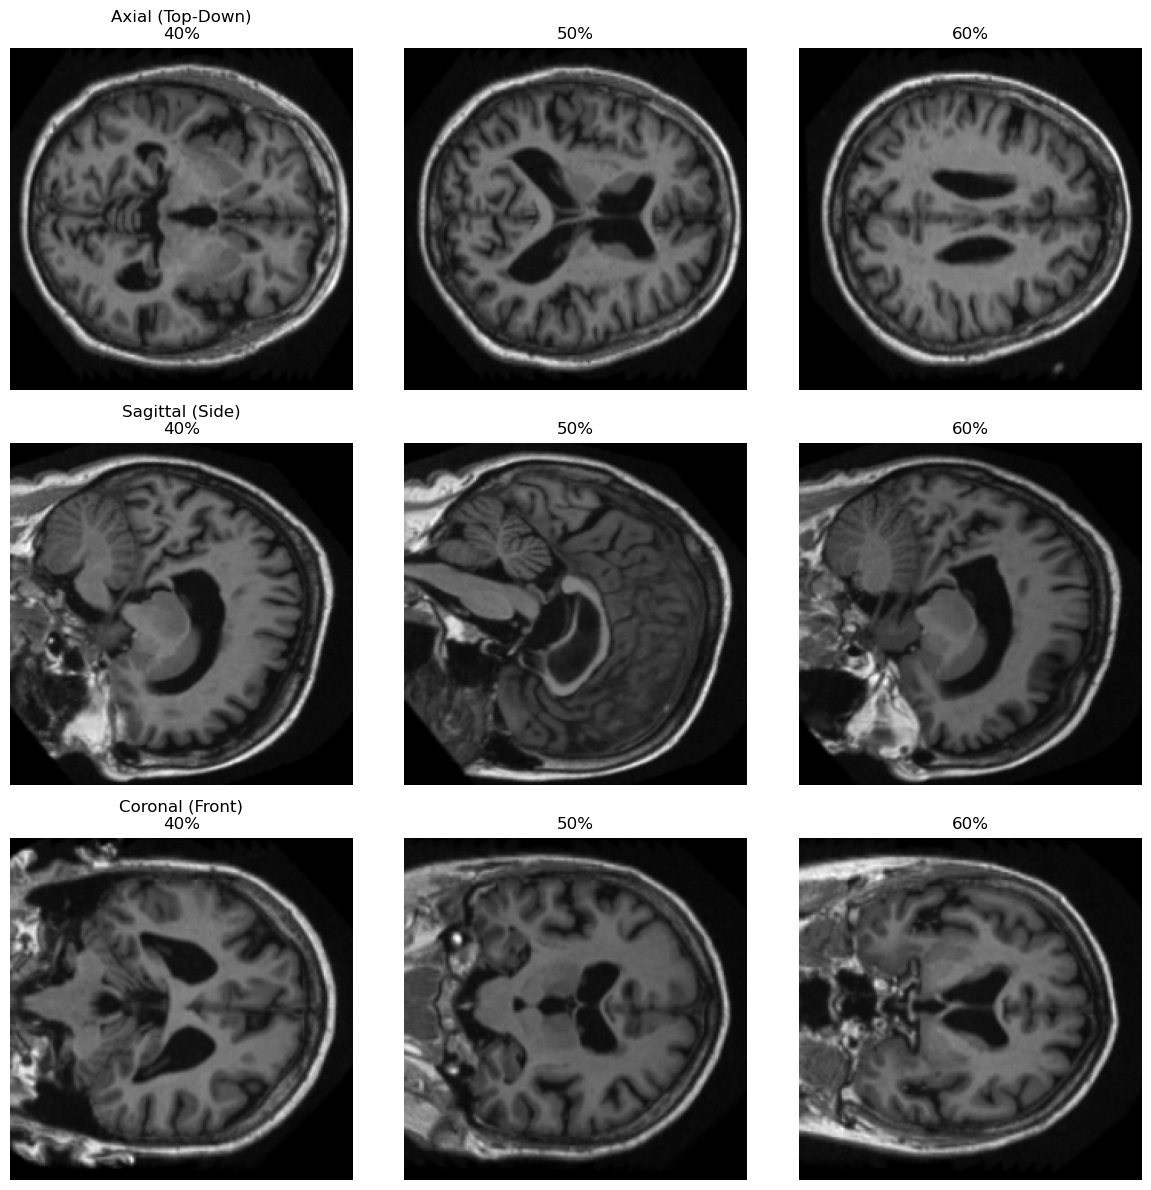

In [5]:
test_first_patient()

Now, let's do some unimodal baselines. First we will use random forests on the tabular data. We impose a max depth of and sqrt max features to prevent overfitting.

In [2]:
train_loader, val_loader, test_loader = get_data_loaders('data')

In [7]:
print("Training tabular baseline...")
tab_model = TabularBaseline()
tab_model.load_data(train_loader, test_loader)
tab_model.train()
tab_acc = tab_model.evaluate()

Training tabular baseline...


Loading test data: 100%|██████████| 2/2 [00:11<00:00,  5.82s/it]


Model Performance Metrics:
Metric               Score
----------------------------------------
Accuracy             0.870
Precision            0.778
Recall               0.583
F1                   0.667

Confusion Matrix:
----------------------------------------
               Predicted
              Neg    Pos
Actual Neg    40     2     
      Pos    5      7     
----------------------------------------

Per-Class Metrics:
----------------------------------------
Class     Precision     Recall         F1
----------------------------------------
0             0.889      0.952      0.920
1             0.778      0.583      0.667
----------------------------------------


Now, onto the MRI data. What's tricky here is the dataloader extracted 9 slices from the MRIs (3 from each plane: sagittal, coronal, and axial). Moving forward, we want to use only one slice (i.e. axial 50%). To select a slice, we train on each of the 9 and choose the one with the highest average accuracy.

In [10]:
print("\nTraining and evaluating one model per slice...")
mri_model = MRIBaseline()
mri_model.load_data(train_loader, test_loader)


Training and evaluating one model per slice...


Loading training data:   0%|          | 0/8 [00:01<?, ?it/s]


KeyboardInterrupt: 

In [11]:
# # Train all models
multi_slice_results = mri_model.train_multi_slice_model(train_loader, test_loader)
single_slice_results = mri_model.train_and_evaluate_per_slice_models(train_loader, test_loader, num_slices=9)

# # Access the models:
# best_single_slice_model = mri_model.model  # Best performing single-slice model
# slice5_model = mri_model.slice5_model  # Model trained on slice 5
multi_slice_model = mri_model.multi_slice_model  # Model trained on all slices


Training model with all slices...


KeyboardInterrupt: 

Well, almost all the slices perform the same so let's proceed with slice 1, a 50% axial slice because I think it has the best vibe. For the sake of completeness, let's also look at GradCAM results from 5 randomly selected patients using the slice 1 model.

Saved Grad-CAM visualizations for 5 patients.


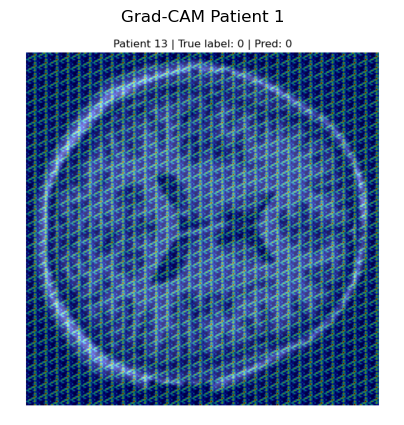

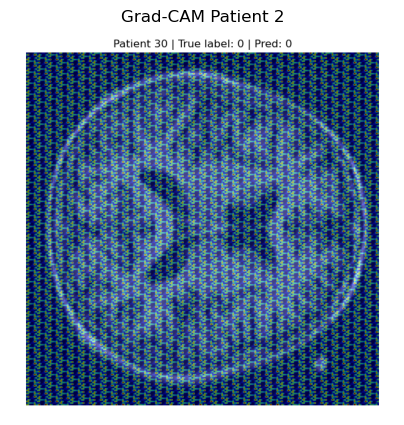

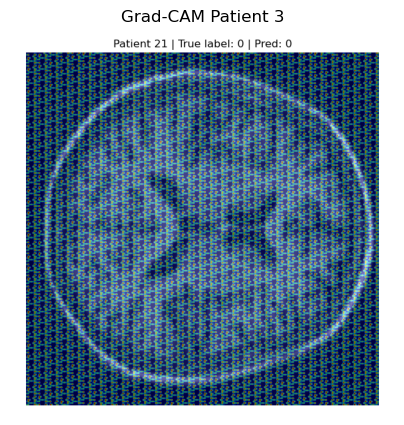

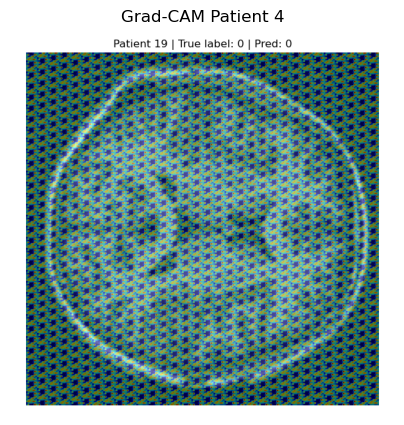

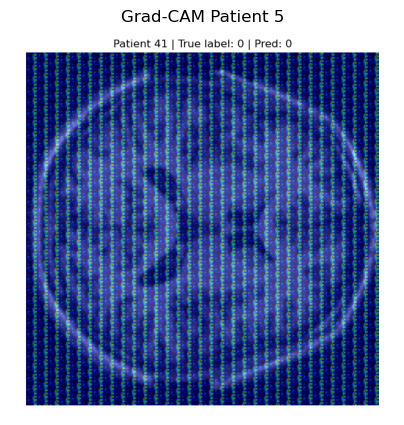

In [10]:
mri_model.apply_gradcam_to_mri(
    device=mri_model.device,
    test_loader=test_loader,
    num_patients=5,
    save_prefix='gradcam_patient'
)

for i in range(1, 6):
    img = Image.open(f'gradcam_patient_{i}.png')
    plt.figure(figsize=(5,5))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Grad-CAM Patient {i}')
    plt.show()

In [3]:
fusion = EarlyFusion()
fusion.fit(train_loader, test_loader, use_slice5=True)
fusion.evaluate(test_loader, use_slice5=True)

Training tabular (RF) baseline...


Loading test data: 100%|██████████| 2/2 [00:12<00:00,  6.05s/it]


Training MRI (CNN) baseline for slice 5 only...


Loading test data: 100%|██████████| 2/2 [00:11<00:00,  5.83s/it]

[DEBUG] Calling train_single_slice_model with slice_idx=5
Training model for slice 5...


[DEBUG] slice_idx value: 5, type: <class 'int'>

Detailed Evaluation Metrics:
Overall Metrics:
--------------------------------------------------
Metric               Score
--------------------------------------------------
Accuracy             0.167
Precision            0.167
Recall               1.000
F1                   0.286
--------------------------------------------------

Confusion Matrix:
--------------------------------------------------
               Predicted
              Neg    Pos
Actual Neg    0      45    
      Pos    0      9     
--------------------------------------------------

Per-Class Metrics:
--------------------------------------------------
Class     Precision     Recall         F1
--------------------------------------------------
0             0.000      0.000      0.000
1             0.167      1.000      0.286
--------------------------------------------------

Average Prediction Probabilities:
--------------------------------------------------
Class 

{'accuracy': 0.8518518518518519,
 'f1': 0.6,
 'precision': 0.5454545454545454,
 'recall': 0.6666666666666666}